In [1]:
# Imports
from shapely.ops import nearest_points
import geopandas as gpd
import pyproj
from shapely.geometry import Polygon, LineString, Point, MultiLineString
from shapely.ops import transform, polygonize, unary_union
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pyproj import Geod
import math
import numpy as np
import json
import pandas as pd

In [2]:
# DEFINE USEFUL FUNCTIONS

def get_utm_zone(lon):
    print(lon)
    return int((lon + 180) // 6) + 1

def get_utm_proj(lon, lat):
    print(lon)
    utm_zone = get_utm_zone(lon)
    is_northern = lat >= 0  # Determine if the zone is in the northern hemisphere
    return f"+proj=utm +zone={utm_zone} +{'north' if is_northern else 'south'} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

# Simplified function to convert a distance in degrees to meters
def degrees_to_meters(distance_in_degrees, utm_proj_rectangle):
    
    # Create transformers for a small unit distance in degrees (1 degree) to meters
    transformer = pyproj.Transformer.from_crs("EPSG:4326", utm_proj_rectangle, always_xy=True)
    
    # Convert 1 degree distance to meters (latitude = 0 because we assume small distance near the UTM zone)
    lon1, lat1 = 0, 0
    lon2, lat2 = 1, 0
    
    x1, y1 = transformer.transform(lon1, lat1)
    x2, y2 = transformer.transform(lon2, lat2)
    
    # Calculate the distance in meters for 1 degree of longitude
    meters_per_degree = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    
    # Convert the input distance in degrees to meters
    distance_in_meters = distance_in_degrees * meters_per_degree
    
    return distance_in_meters

def calculate_area_geodesic(rectangle):
    # Create a Geod object for geodesic calculations
    geod = Geod(ellps="WGS84")

    # Calculate the area using the geod object. The area is returned in square meters.
    area, _ = geod.geometry_area_perimeter(rectangle.geometry[0])

    return abs(area)

In [3]:
# Read needed files: rectangle, buildings, streets

tile_id = 1
rectangles = gpd.read_file('./data/rectangles.geojson')
rectangle = rectangles[rectangles.n==tile_id]
rectangle_centroid = rectangle.geometry[0].centroid
utm_proj_rectangle = get_utm_proj(rectangle_centroid.x,rectangle_centroid.y)
rectangle_area = calculate_area_geodesic(rectangle)
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), utm_proj_rectangle, always_xy=True).transform # This seems to be a repetitive task; gotta turn it into a function.
rectangle_projected = transform(project, rectangle.geometry[0])

OSM_buildings = gpd.read_file(f"./output_data/OSM_buildings_{tile_id}.gpkg")
OSM_roads = gpd.read_file(f"./output_data/OSM_roads_{tile_id}.gpkg")
OSM_intersections = gpd.read_file(f"./output_data/OSM_intersections_{tile_id}.gpkg")

Overture_data = gpd.read_file(f"./output_data/Overture_building_{tile_id}.geojson").to_crs(utm_proj_rectangle)#.clip(rectangle['geometry'])
Overture_data['confidence'] = Overture_data.sources.apply(lambda x: json.loads(x)[0]['confidence'])
Overture_data['dataset'] = Overture_data.sources.apply(lambda x: json.loads(x)[0]['dataset'])

buildings_OSM = OSM_buildings[(OSM_buildings.building=='yes')].to_crs(utm_proj_rectangle)
Overture_data = Overture_data.set_geometry('geometry')[Overture_data.dataset!='OpenStreetMap']
buildings_OSM = buildings_OSM.set_geometry('geometry')

roads = OSM_roads.to_crs(utm_proj_rectangle)
road_union = roads.to_crs(utm_proj_rectangle).unary_union # Create a unary union of the road geometries to simplify distance calculation
buildings = gpd.GeoDataFrame(pd.concat([buildings_OSM, Overture_data], axis=0, ignore_index=True, join='outer')).drop_duplicates('geometry')
roads_rectangle = roads.clip(rectangle_projected)

43.08535305010083
43.08535305010083


In [4]:
# Function to calculate the shortest distance to roads
def calculate_minimum_distance_to_roads(building, road_union,utm_proj_rectangle):

    #nearest_geom = nearest_points(crs_transform(building), crs_transform(road_union))[1] #distance to closest road, given the input order
    nearest_geom = nearest_points(building, road_union)[1] #distance to closest road, given the input order
    return building.distance(nearest_geom)#degrees_to_meters(building.distance(nearest_geom), utm_proj_rectangle) 

# Apply the distance calculation to each building
buildings.loc[:,'distance_to_road'] = buildings['geometry'].apply(lambda x: x.centroid).apply(calculate_minimum_distance_to_roads, road_union=road_union, utm_proj_rectangle=utm_proj_rectangle)


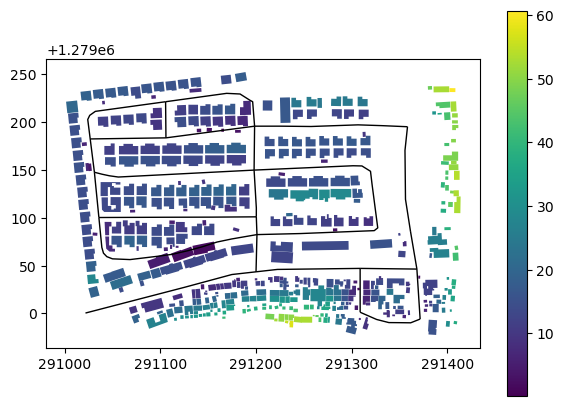

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
buildings.plot(column='distance_to_road', ax=ax, legend=True, cmap='viridis')
#roads_clipped = roads.clip(rectangle['geometry'])
roads.plot(ax=ax, color='black', linewidth=1)
plt.show()


In [6]:
buildings['distance_to_road'].describe()

count    424.000000
mean      20.342373
std       12.540910
min        0.170147
25%       12.071597
50%       15.858875
75%       26.756828
max       60.626468
Name: distance_to_road, dtype: float64

In [ ]:
# Intersections

In [ ]:

# Block polygons

In [ ]:

# City block width

In [7]:
# Calculate measures
buildings['distance_to_road'].describe()

count    424.000000
mean      20.342373
std       12.540910
min        0.170147
25%       12.071597
50%       15.858875
75%       26.756828
max       60.626468
Name: distance_to_road, dtype: float64

In [8]:
#1 Share of building footprints that are less than 10-meters away from the nearest road

def metric_1_distance_less_than_10m(buildings):
    return 100.*((sum(buildings['distance_to_road']<=10))/len(buildings))

metric_1_distance_less_than_10m(buildings)

17.68867924528302

In [9]:
#2 Average distance of building footprint centroids to roads
def metric_2_average_distance_to_roads(buildings):
    return buildings['distance_to_road'].mean()

metric_2_average_distance_to_roads(buildings)


20.342373213761217

In [ ]:
roads_rectangle

In [10]:
#3 Density of roads
def metric_3_road_density(roads_rectangle,rectangle_area):
    #meter_length = degrees_to_meters(road_union.length,utm_zone_rectangle=utm_zone_rectangle)
    km_length = roads_rectangle.length.sum()/1000.
    rectangle_area_km2 = rectangle_area/1000000.
    return km_length/rectangle_area_km2

metric_3_road_density(roads_rectangle,rectangle_area)

23.155190110468748

In [ ]:
#9 Tortuosity index
OSM_intersections

In [ ]:
OSM_intersections.street_count.value_counts()

In [11]:
#4 Share of 3-way and 4-way intersections 
def metric_4_share_3_and_4way_intersections(intersections):
    n_intersections_3_and_4 = 1.*len(intersections[(intersections.street_count == 4)|(intersections.street_count == 3)])
    n_4_way = 1.*len(intersections[(intersections.street_count == 4)])
    return (n_4_way / n_intersections_3_and_4)

metric_4_share_3_and_4way_intersections(OSM_intersections)

0.29411764705882354

In [12]:
#5 Number of 4-way intersections
def metric_5_4way_intersections(intersections):
    return 1.*len(intersections[(intersections.street_count == 4)])
metric_5_4way_intersections(OSM_intersections)

5.0

In [13]:
buildings['geometry'].iloc[7].exterior.coords[0]

(291320.0863472408, 1279172.738390088)

In [14]:
#6 Average building footprint orientation of the tile

def longest_segment(polygon):
    # Ensure the input is a valid Polygon
    if not isinstance(polygon, Polygon):
        raise TypeError("The input must be a shapely Polygon object.")
    
    # Get the exterior coordinates of the polygon
    exterior_coords = polygon.exterior.coords
    
    # Initialize variables to track the longest segment
    max_length = 0
    longest_segment = None
    
    # Iterate through the exterior coordinates to find the longest segment
    for i in range(len(exterior_coords) - 1):
        # Create a line segment from consecutive coordinates
        segment = LineString([exterior_coords[i], exterior_coords[i+1]])
        
        # Calculate the length of the segment
        segment_length = segment.length
        
        # Update the longest segment if this one is longer
        if segment_length > max_length:
            max_length = segment_length
            longest_segment = segment
    
    return longest_segment

#longest_seg = longest_segment(polygon)



def calculate_azimuth(segment):
    # Extract start and end points of the segment
    start_point = segment.coords[0]
    end_point = segment.coords[1]
    
    # Calculate the difference in coordinates
    delta_x = end_point[0] - start_point[0]
    delta_y = end_point[1] - start_point[1]
    
    # Calculate the azimuth in radians
    azimuth_rad = math.atan2(delta_x, delta_y)
    
    # Convert the azimuth to degrees
    azimuth_deg = math.degrees(azimuth_rad)
    
    # Normalize the azimuth to be within 0 to 360 degrees
    #if azimuth_deg < 0:
    #    azimuth_deg += 360
    
    return np.abs(azimuth_deg)

# Assuming you have the longest segment from the previous example
#azimuth = calculate_azimuth(longest_seg)

buildings.loc[:,'azimuth'] = buildings['geometry'].apply(lambda x: calculate_azimuth(longest_segment(x)))

def metric_6_deviation_of_building_azimuth(buildings):
    return buildings.azimuth.std()/180.

print(metric_6_deviation_of_building_azimuth(buildings))
buildings.azimuth.describe()

0.323289127696127


count    424.000000
mean      88.431012
std       58.192043
min        0.008704
25%       75.217636
50%       89.847769
75%       96.411192
max      179.956446
Name: azimuth, dtype: float64

In [15]:
# Function to calculate the angle between two vectors
def calculate_angle(vector1, vector2):
    angle = np.arctan2(vector2[1], vector2[0]) - np.arctan2(vector1[1], vector1[0])
    angle = np.degrees(angle)
    if angle < 0:
        angle += 360
    return angle

def calculate_sequential_angles(intersections, roads):
    records = []  # List to store angle records
    
    # Iterate through each intersection
    for _, intersection in intersections.iterrows():
        intersection_id = intersection['osmid']
        intersection_point = intersection.geometry
        
        # Get all roads connected to the intersection
        connected_roads = roads[(roads['u'] == intersection_id) | (roads['v'] == intersection_id)]
        vectors = []
        
        for _, road in connected_roads.iterrows():
            coords = list(road.geometry.coords)
            
            # Determine the vector for the road segment away from the intersection
            if road['u'] == intersection_id:
                vector = (coords[1][0] - coords[0][0], coords[1][1] - coords[0][1])
            else:
                vector = (coords[-2][0] - coords[-1][0], coords[-2][1] - coords[-1][1])
            
            vectors.append((vector, road['u'], road['v']))
        
        # Sort vectors based on the angle relative to a fixed axis (e.g., x-axis)
        vectors.sort(key=lambda v: np.arctan2(v[0][1], v[0][0]))

        # Calculate the sequential angles between each pair of vectors
        for i in range(len(vectors)):
            vector1 = vectors[i][0]
            vector2 = vectors[(i + 1) % len(vectors)][0]  # Next vector, looping back to the start
            angle = calculate_angle(vector1, vector2)
            
            record = {
                'Intersection ID': intersection_id,
                'Segment 1': (vectors[i][1], vectors[i][2]),
                'Segment 2': (vectors[(i + 1) % len(vectors)][1], vectors[(i + 1) % len(vectors)][2]),
                'Angle': angle
            }
            records.append(record)
    
    # Create a DataFrame from the records
    df_angles = pd.DataFrame(records)
    
    return df_angles

In [16]:
#10 Average angle between road segments
def metric_10_average_angle_between_road_segments(df_angles,OSM_intersections):
    intersection_angles_df = OSM_intersections[['osmid','street_count']].set_index('osmid').merge(df_angles.set_index('Intersection ID'),left_index=True,right_index=True,how='outer')

    # In 3-way intersections, include only the smallest angle in the tile average. 
    df_3_way = intersection_angles_df[(intersection_angles_df.street_count==3)]
    to_keep_3 = df_3_way.reset_index().loc[(df_3_way.reset_index().groupby(df_3_way.index)['Angle'].idxmin())].set_index('index')

    # In 4-way intersections, include only the two smallest angles in the tile average.
    df_4_way = intersection_angles_df[intersection_angles_df.street_count==4]
    to_keep_4 = df_4_way.groupby(df_4_way.index).apply(lambda x: x.nsmallest(2, 'Angle')).reset_index().set_index('level_0')
    to_keep_4.index.names = ['index']

    return pd.concat([to_keep_3,to_keep_4])['Angle'].mean()
    
df_angles = calculate_sequential_angles(OSM_intersections, OSM_roads)
metric_10_average_angle_between_road_segments(df_angles= df_angles, OSM_intersections= OSM_intersections)

95.3316544146075

In [17]:
# Get blocks
def get_blocks(road_union, roads):
    # Use polygonize to create polygons from the merged lines
    blocks = list(polygonize(road_union))
    blocks_gdf = gpd.GeoDataFrame(geometry=blocks, crs=roads.crs)
    # Filter out very small polygons if necessary
    blocks_gdf = blocks_gdf[blocks_gdf.area > 9]
    blocks_gdf['area'] = blocks_gdf.area
    #blocks_gdf.to_file("blocks_tile1.gpkg", driver="GPKG")
    return blocks_gdf.sort_values('area')

blocks = get_blocks(road_union, roads)

In [87]:
# Get largest circle inscribed in block

def get_largest_inscribed_circle(block):
    polygon = block
    # Initial guess: the centroid of the polygon
    centroid = polygon.geometry.centroid
    initial_guess = [centroid.x, centroid.y]

    # Calculate negative radius to maximize
    def negative_radius(point_coords):
        point = Point(point_coords)

        if polygon.geometry.contains(point):
            return -polygon.geometry.boundary.distance(point)
        else:
            return np.inf  # Outside the polygon, so invalid

    # Optimization to find the largest inscribed circle
    result = minimize(negative_radius, initial_guess, method='Nelder-Mead')

    # Get the maximum inscribed circle
    optimal_point = Point(result.x)
    max_radius = -result.fun  # Negative of the minimized value

    #print(f"Largest circle center: {optimal_point}")
    #print(f"Maximum radius: {max_radius}")
    return optimal_point, max_radius

optimal_point, max_radius = get_largest_inscribed_circle(blocks.iloc[0])

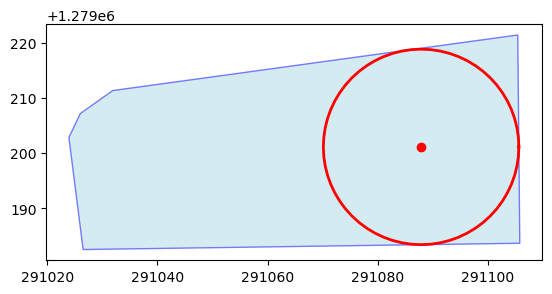

In [88]:
def draw_optimal_circle(block,optimal_point,max_radius):
    circle = optimal_point.buffer(max_radius)

    # Plot the block polygon
    fig, ax = plt.subplots()
    x, y = block.geometry.exterior.xy
    ax.fill(x, y, alpha=0.5, fc='lightblue', ec='blue')  # Draw the polygon

    # Plot the circle
    x, y = circle.exterior.xy
    ax.plot(x, y, color='red', linewidth=2)  # Draw the circle

    # Plot the optimal point (center of the circle)
    ax.plot(optimal_point.x, optimal_point.y, 'ro')  # Red point for the center

    # Set limits and show the plot
    #ax.set_xlim(-1, 5)
    #ax.set_ylim(-1, 4)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

draw_optimal_circle(blocks.iloc[0],optimal_point,max_radius)

In [83]:
blocks.iloc[0].area

2631.1761646896925

In [95]:
#7 Average block width
def metric_7_average_block_width(blocks):
    max_area = max(blocks['area'])  
    min_area = min(blocks['area'])
    for block_id, block in blocks.iterrows():
        optimal_point, max_radius = get_largest_inscribed_circle(block)
        blocks.loc[block_id,'weighted_width'] = (((max_radius*block['area'])-min_area)/max_area)
    return blocks, blocks['weighted_width'].mean()
    
blocks = get_blocks(road_union,roads)
blocks, m_7 = metric_7_average_block_width(blocks)
blocks.to_file("blocks_tile1_with_weighted_width.gpkg", driver="GPKG")


In [94]:
blocks

10.592997565064692

<class 'shapely.geometry.polygon.Polygon'>


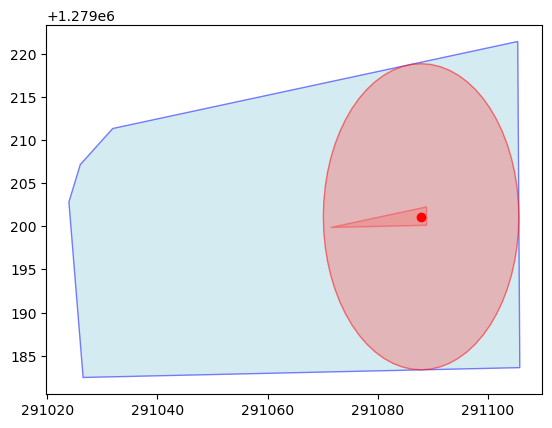

<class 'shapely.geometry.polygon.Polygon'>


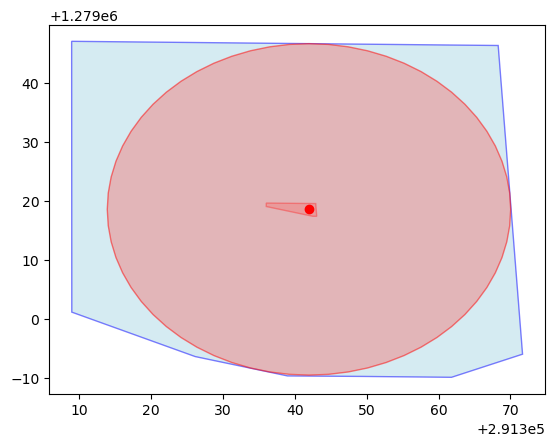

<class 'shapely.geometry.polygon.Polygon'>


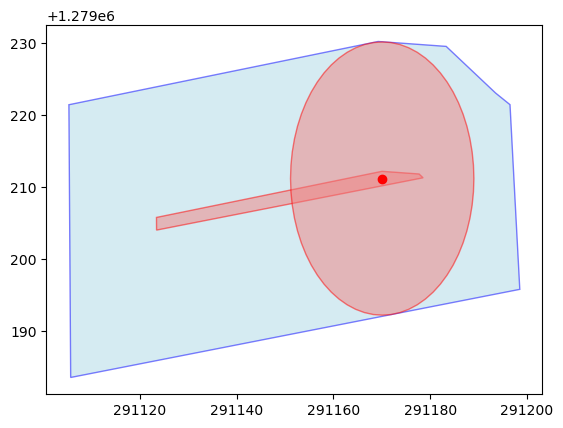

<class 'shapely.geometry.polygon.Polygon'>


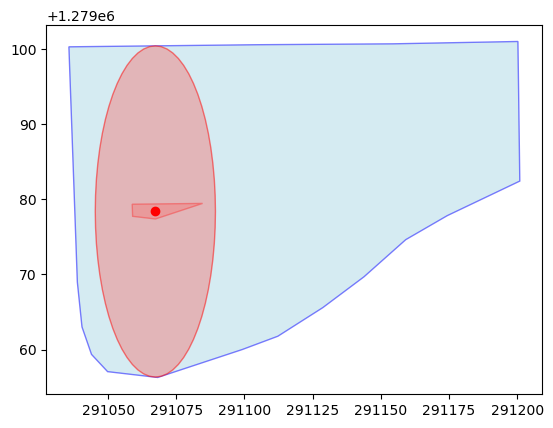

<class 'shapely.geometry.polygon.Polygon'>


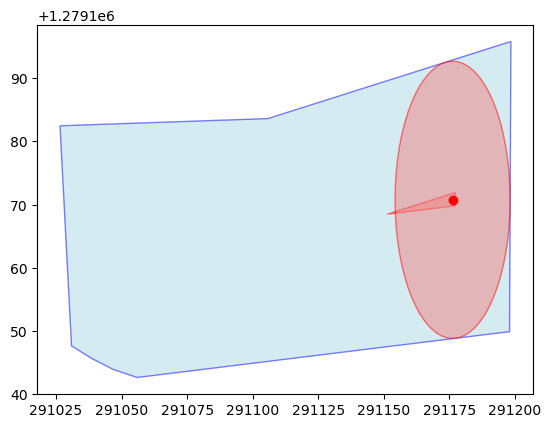

<class 'shapely.geometry.polygon.Polygon'>


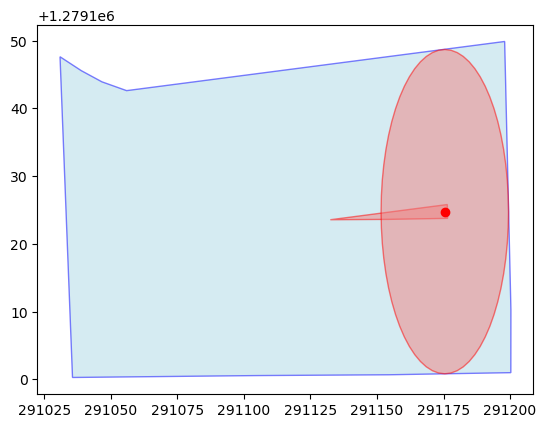

<class 'shapely.geometry.polygon.Polygon'>


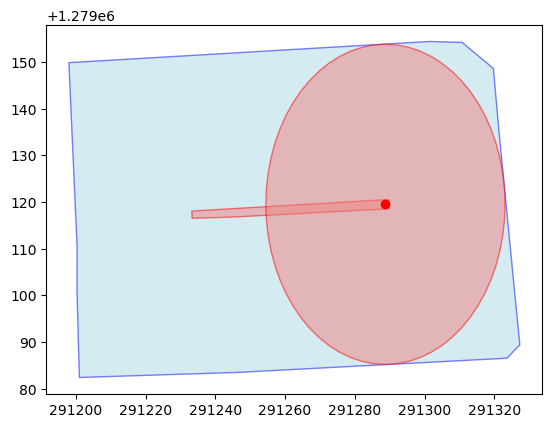

<class 'shapely.geometry.polygon.Polygon'>


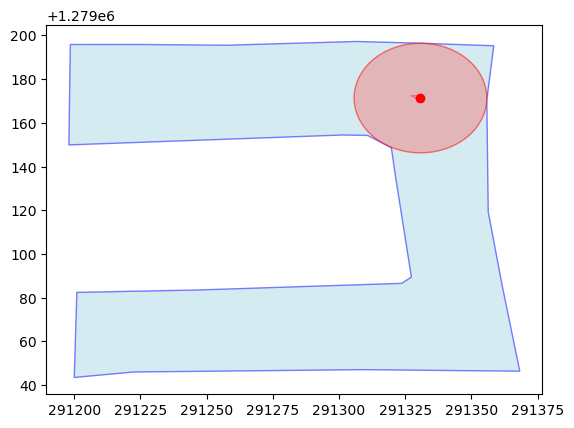

True

In [114]:
#8 Two row blocks
# Compare the area of the buffer inside the block with a width equal to the radius of the largest circle fully contained within 
# the block minus a miniscule amount and the area of the union of the buffer and all the building footprints within the block. 
# If the two are equal, then the block is a two-row subdivision. If the latter is greater, it is not. 
# It may be a hybrid subdivision 
def metric_8_two_row_blocks(blocks, row_epsilon, buildings):
    for block_id, block in blocks.iterrows():
        print(type(block.geometry))
        optimal_point, max_radius = get_largest_inscribed_circle(block)
        fig, ax = plt.subplots()
        # Plot the original polygon
        x, y = block.geometry.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='lightblue', ec='blue', label='Original Polygon')
        # Ojo: buffer
        internal_buffer = block.geometry.buffer(-max_radius+row_epsilon)
        x, y = .exterior.xy
        ax.fill(x, y, alpha=0.5, fc='lightcoral', ec='red', label='Internal Buffer')
        x,y = optimal_point.buffer(max_radius).exterior.xy
        ax.fill(x, y, alpha=0.5, fc='lightcoral', ec='red', label='Optimal circle')
        ax.plot(optimal_point.x, optimal_point.y, 'ro')
        plt.show()
        # join buffer aand


    return True
metric_8_two_row_blocks(blocks,row_epsilon=1)